# Towards Total Recall in Industrial Anomaly Detection

- **Author**: Jaehyuk Heo
- **Paper**: https://arxiv.org/pdf/2106.08265.pdf
- **Github**: https://github.com/amazon-research/patchcore-inspection


**장점**
- 학습 안해서 학습 시간 없음

**단점**
- similarity 연산량이 너무 큼

In [87]:
%reload_ext autoreload
%autoreload 2

import contextlib

import torch
import common
import sampler
import patchcore
import backbones
import metrics
import utils

from dataset import SeverstalDataset, DatasetSplit

import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
from typing import Union, List

import matplotlib.pyplot as plt
import os

# DataLoader

In [88]:
def create_dataloader(
    source,  # 'data_path'를 'source'로 변경하였습니다. 이 이름은 클래스 생성자와 일치해야 합니다.
    classname,  # Severstal 데이터셋에서 사용할 클래스 이름을 추가합니다.
    train_val_split,
    batch_size,
    imagesize,
    num_workers
):
    train_dataset = SeverstalDataset(
        source=source,
        classname=classname,  # 클래스 이름을 전달합니다.
        imagesize=imagesize,
        split=DatasetSplit.TRAIN,
        train_val_split=train_val_split
    )

    test_dataset = SeverstalDataset(
        source=source,
        classname=classname,  # 클래스 이름을 전달합니다.
        imagesize=imagesize,
        split=DatasetSplit.TEST
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader

In [89]:
train_dataloader, test_dataloader = create_dataloader(
    source='../Datasets/Severstal',  # 데이터셋의 경로를 올바르게 지정
    classname='steel',  # Severstal 데이터셋에서 사용할 클래스 이름
    train_val_split=1.0,
    batch_size=20,
    imagesize=(400, 256),  # 이미지 크기를 튜플로 전달
    num_workers=8
)

In [90]:
train_dataloader.dataset[0]

{'image': tensor([[[-0.8849, -0.9192, -0.9363,  ..., -0.6794, -0.6281, -0.5596],
          [-0.8849, -0.9192, -0.9363,  ..., -0.6794, -0.6281, -0.5596],
          [-0.8849, -0.9192, -0.9363,  ..., -0.6794, -0.6281, -0.5767],
          ...,
          [-0.5596, -0.5424, -0.5424,  ...,  0.0227,  0.0056,  0.0398],
          [-0.5424, -0.5253, -0.5253,  ...,  0.0056,  0.0227,  0.0569],
          [-0.5424, -0.5253, -0.5253,  ...,  0.0056,  0.0227,  0.0741]],
 
         [[-0.7752, -0.8102, -0.8277,  ..., -0.5651, -0.5126, -0.4426],
          [-0.7752, -0.8102, -0.8277,  ..., -0.5651, -0.5126, -0.4426],
          [-0.7752, -0.8102, -0.8277,  ..., -0.5651, -0.5126, -0.4601],
          ...,
          [-0.4426, -0.4251, -0.4251,  ...,  0.1527,  0.1352,  0.1702],
          [-0.4251, -0.4076, -0.4076,  ...,  0.1352,  0.1527,  0.1877],
          [-0.4251, -0.4076, -0.4076,  ...,  0.1352,  0.1527,  0.2052]],
 
         [[-0.5495, -0.5844, -0.6018,  ..., -0.3404, -0.2881, -0.2184],
          [-0.5495,

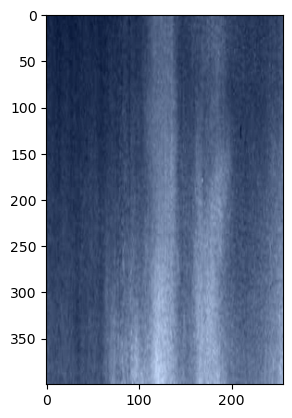

In [91]:
img = train_dataloader.dataset[0]['image'].permute(1,2,0)
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

# Model

In [92]:
device = utils.set_torch_device(gpu_ids=[0])
# device = torch.device("cpu")

In [93]:
patch_core = patchcore.PatchCore(device)                    # Setting computing device

In [94]:
# example_data = next(iter(train_dataloader))
# print(example_data['image'].shape)

In [95]:
patch_core.load(
    backbone                 = backbones.load('wideresnet50'),
    layers_to_extract_from   = ['layer4'],
    device                   = device,
    input_shape              = train_dataloader.dataset.imagesize,
    pretrain_embed_dimension = 1024,
    target_embed_dimension   = 1024,
    patchsize                = 3,
    anomaly_scorer_num_nn    = 5,
    featuresampler           = sampler.GreedyCoresetSampler(percentage=0.1, device=device),
    nn_method                = common.FaissNN(on_gpu=True, num_workers=8)
)

# Sample Images

In [96]:
batch_temp = next(iter(train_dataloader))

In [97]:
# 배치 크기, 채널 수 (RGB), img 높이, 너비
images = batch_temp['image']
images = images.to(torch.float).to(patch_core.device)

print('images.size: ',images.size())

images.size:  torch.Size([20, 3, 400, 256])


# Fitting

## 1. Extract Features

In [98]:
def _detach(features):
    if detach:
        return [x.detach().cpu().numpy() for x in features]
    return features

In [99]:
_ = patch_core.forward_modules["feature_aggregator"].eval()

with torch.no_grad():
    features = patch_core.forward_modules["feature_aggregator"](images)

In [100]:
print('layer list: ',features.keys())
print("features['layer4'].size(): ",features['layer4'].size())

layer list:  dict_keys(['layer4'])
features['layer4'].size():  torch.Size([20, 2048, 13, 8])


## 2. Patchfying

In [101]:
# extract features from selected layers
features = [features[layer] for layer in patch_core.layers_to_extract_from]

# patchfying features
features = [
    patch_core.patch_maker.patchify(x, return_spatial_info=True) for x in features
]

In [102]:
# batch
print("len(features): ",len(features))

# features with number of total patches
print("len(features[0]): ",len(features[0]))

len(features):  1
len(features[0]):  2


In [103]:
# unfold results
print("features[0][0].size(): ",features[0][0].size())

# number of total patches
print('features[0][1]: ',features[0][1])

features[0][0].size():  torch.Size([20, 104, 2048, 3, 3])
features[0][1]:  [13, 8]


In [104]:
patch_shapes = [x[1] for x in features]
features = [x[0] for x in features]
ref_num_patches = patch_shapes[0]

In [105]:
print('patch_shapes: ',patch_shapes)

patch_shapes:  [[13, 8]]


In [106]:
for i in range(1, len(features)):
    _features = features[i]
    patch_dims = patch_shapes[i]

    # TODO(pgehler): Add comments
    
    # _features = (Batch size x feature map height x feature map width x channels x patch height x patch width)
    _features = _features.reshape(
        _features.shape[0], patch_dims[0], patch_dims[1], *_features.shape[2:]
    )
    
    # _features = (Batch size x channels x patch height x patch width x feature map height x feature map width)
    _features = _features.permute(0, -3, -2, -1, 1, 2)
    perm_base_shape = _features.shape

    # _features = ((Batch size x channels x patch height x patch width) x feature map height x feature map width)        
    _features = _features.reshape(-1, *_features.shape[-2:])
    
    # _features = ((Batch size x channels x patch height x patch width) x 1 x ref height x ref width)
    _features = F.interpolate(
        _features.unsqueeze(1),
        size=(ref_num_patches[0], ref_num_patches[1]),
        mode="bilinear",
        align_corners=False,
    )
    
    _features = _features.squeeze(1)
    
    # _features = (Batch size x channels x patch height x patch width x ref height x ref width)
    _features = _features.reshape(
        *perm_base_shape[:-2], ref_num_patches[0], ref_num_patches[1]
    )
    
    # _features = (Batch size x ref height x ref width x channels x patch height x patch width)
    _features = _features.permute(0, -2, -1, 1, 2, 3)
    
    # _features = (Batch size x (ref height x ref width) x channels x patch height x patch width)
    _features = _features.reshape(len(_features), -1, *_features.shape[-3:])
    features[i] = _features
    
    
# _features = ((Batch size x (ref height x ref width)) x channels x patch height x patch width)
features = [x.reshape(-1, *x.shape[-3:]) for x in features]

In [107]:
print('features[0].shape: ',features[0].shape)
# print('features[1].shape: ',features[1].shape)

features[0].shape:  torch.Size([2080, 2048, 3, 3])


## 3. Aggregation

In [108]:
# ========================
# preprocessing
# ========================
class Preprocessing(torch.nn.Module):
    def __init__(self, input_dims, output_dim):
        super(Preprocessing, self).__init__()
        self.input_dims = input_dims
        self.output_dim = output_dim

        self.preprocessing_modules = torch.nn.ModuleList()
        for input_dim in input_dims:
            module = MeanMapper(output_dim)
            self.preprocessing_modules.append(module)

    def forward(self, features):
        _features = []
        for module, feature in zip(self.preprocessing_modules, features):
            _features.append(module(feature))
        return torch.stack(_features, dim=1)


class MeanMapper(torch.nn.Module):
    def __init__(self, preprocessing_dim):
        super(MeanMapper, self).__init__()
        self.preprocessing_dim = preprocessing_dim

    def forward(self, features):
        features = features.reshape(len(features), 1, -1)
        return F.adaptive_avg_pool1d(features, self.preprocessing_dim).squeeze(1)
    
# ========================
# preadapt_aggregator
# ========================
class Aggregator(torch.nn.Module):
    def __init__(self, target_dim):
        super(Aggregator, self).__init__()
        self.target_dim = target_dim

    def forward(self, features):
        """Returns reshaped and average pooled features."""
        # batchsize x number_of_layers x input_dim -> batchsize x target_dim
        features = features.reshape(len(features), 1, -1)
        features = F.adaptive_avg_pool1d(features, self.target_dim)
        return features.reshape(len(features), -1)

In [109]:
features = patch_core.forward_modules["preprocessing"](features)

In [110]:
print('features.size(): ',features.size())

features.size():  torch.Size([2080, 1, 1024])


In [111]:
features = patch_core.forward_modules["preadapt_aggregator"](features)

In [112]:
print('features.size(): ',features.size())

features.size():  torch.Size([2080, 1024])


## 1 ~ 3. Apply total train data

In [113]:
_ = patch_core.forward_modules.eval()

def _image_to_features(input_image):
    with torch.no_grad():
        input_image = input_image.to(torch.float).to(patch_core.device)
        return patch_core._embed(input_image)

features = []
with tqdm(
    train_dataloader, desc="Computing support features...", position=1, leave=False
) as data_iterator:
    for image in data_iterator:
        if isinstance(image, dict):
            image = image["image"]
        features.append(_image_to_features(image))

features = np.concatenate(features, axis=0)

Computing support features...:   0%|          | 0/12 [00:01<?, ?it/s]

In [114]:
print('features.shape: ',features.shape)

features.shape:  (23712, 1024)


## 4. Sampler

In [115]:
class GreedyCoresetSampler(sampler.BaseSampler):
    def __init__(
        self,
        percentage: float,
        device: torch.device,
        dimension_to_project_features_to=128,
    ):
        """Greedy Coreset sampling base class."""
        super().__init__(percentage)

        self.device = device
        self.dimension_to_project_features_to = dimension_to_project_features_to

    def _reduce_features(self, features):
        if features.shape[1] == self.dimension_to_project_features_to:
            return features
        mapper = torch.nn.Linear(
            features.shape[1], self.dimension_to_project_features_to, bias=False
        )
        _ = mapper.to(self.device)
        features = features.to(self.device)
        return mapper(features)

    def run(
        self, features: Union[torch.Tensor, np.ndarray]
    ) -> Union[torch.Tensor, np.ndarray]:
        """Subsamples features using Greedy Coreset.
        Args:
            features: [N x D]
        """
        if self.percentage == 1:
            return features
        self._store_type(features)
        if isinstance(features, np.ndarray):
            features = torch.from_numpy(features)
        reduced_features = self._reduce_features(features)
        sample_indices = self._compute_greedy_coreset_indices(reduced_features)
        features = features[sample_indices]
        return self._restore_type(features)

    @staticmethod
    # def _compute_batchwise_differences(
    #     matrix_a: torch.Tensor, matrix_b: torch.Tensor
    # ) -> torch.Tensor:
    #     """Computes batchwise Euclidean distances using PyTorch."""
    #     a_times_a = matrix_a.unsqueeze(1).bmm(matrix_a.unsqueeze(2)).reshape(-1, 1)
    #     b_times_b = matrix_b.unsqueeze(1).bmm(matrix_b.unsqueeze(2)).reshape(1, -1)
    #     a_times_b = matrix_a.mm(matrix_b.T)

    #     return (-2 * a_times_b + a_times_a + b_times_b).clamp(0, None).sqrt()
    
    def _compute_batchwise_differences(matrix_a: torch.Tensor, matrix_b: torch.Tensor) -> torch.Tensor:
        # CPU로 텐서 이동
        matrix_a = matrix_a.to('cpu')
        matrix_b = matrix_b.to('cpu')
        
        a_times_a = matrix_a.unsqueeze(1).bmm(matrix_a.unsqueeze(2)).reshape(-1, 1)
        b_times_b = matrix_b.unsqueeze(1).bmm(matrix_b.unsqueeze(2)).reshape(1, -1)
        a_times_b = matrix_a.mm(matrix_b.T)
    
        return (-2 * a_times_b + a_times_a + b_times_b).clamp(0, None).sqrt()

    def _compute_greedy_coreset_indices(self, features: torch.Tensor) -> np.ndarray:
        """Runs iterative greedy coreset selection.
        Args:
            features: [NxD] input feature bank to sample.
        """
        # distance_matrix = ((batch size x ref height x ref width) x (batch size x ref height x ref width))
        distance_matrix = self._compute_batchwise_differences(features, features)
        
        # coreset_anchor_distances = (batch size x ref height x ref width)
        coreset_anchor_distances = torch.norm(distance_matrix, dim=1)

        coreset_indices = []
        num_coreset_samples = int(len(features) * self.percentage)

        for _ in range(num_coreset_samples):
            select_idx = torch.argmax(coreset_anchor_distances).item()
            coreset_indices.append(select_idx)

            coreset_select_distance = distance_matrix[
                :, select_idx : select_idx + 1  # noqa E203
            ]
            
            coreset_anchor_distances = torch.cat(
                [coreset_anchor_distances.unsqueeze(-1), coreset_select_distance], dim=1
            )
            coreset_anchor_distances = torch.min(coreset_anchor_distances, dim=1).values

        return np.array(coreset_indices)


In [116]:
featuresampler = GreedyCoresetSampler(percentage=0.1, device=device)

### Reduce Dimension

In [117]:
featuresampler._store_type(features)
features = torch.from_numpy(features)

In [118]:
reduced_features = featuresampler._reduce_features(features)

In [119]:
print('features.size(): ',features.size())
print('reduced_features.size(): ',reduced_features.size())

features.size():  torch.Size([23712, 1024])
reduced_features.size():  torch.Size([23712, 128])


### Greedy Search

In [120]:
distance_matrix = featuresampler._compute_batchwise_differences(reduced_features, reduced_features)

In [121]:
print('distance_matrix.size(): ',distance_matrix.size())

distance_matrix.size():  torch.Size([23712, 23712])


In [122]:
coreset_anchor_distances = torch.norm(distance_matrix, dim=1)

In [123]:
print('coreset_anchor_distances.size(): ',coreset_anchor_distances.size())

coreset_anchor_distances.size():  torch.Size([23712])


In [124]:
coreset_indices = []
num_coreset_samples = int(len(features) * featuresampler.percentage)

for _ in range(num_coreset_samples):
    select_idx = torch.argmax(coreset_anchor_distances).item()
    coreset_indices.append(select_idx)

    coreset_select_distance = distance_matrix[
        :, select_idx : select_idx + 1  # noqa E203
    ]

    coreset_anchor_distances = torch.cat(
        [coreset_anchor_distances.unsqueeze(-1), coreset_select_distance], dim=1
    )
    coreset_anchor_distances = torch.min(coreset_anchor_distances, dim=1).values
    
coreset_indices = np.array(coreset_indices)

In [125]:
print('coreset_indices.shape: ',coreset_indices.shape)

coreset_indices.shape:  (2371,)


In [126]:
features = featuresampler._restore_type(features[coreset_indices])

In [127]:
print('features.shape: ',features.shape)

features.shape:  (2371, 1024)


## 5. NearestNeighbourScorer

In [128]:
patch_core.anomaly_scorer.detection_features = patch_core.anomaly_scorer.feature_merger.merge([features])

In [129]:
patch_core.anomaly_scorer.nn_method.search_index = patch_core.anomaly_scorer.nn_method._create_index(
    dimension = patch_core.anomaly_scorer.detection_features.shape[-1]
)

In [130]:
patch_core.anomaly_scorer.nn_method._train(
    patch_core.anomaly_scorer.nn_method.search_index,
    patch_core.anomaly_scorer.detection_features
)

In [131]:
patch_core.anomaly_scorer.nn_method.search_index.add(
    patch_core.anomaly_scorer.detection_features
)

## 1 ~ 6. Fitting

In [132]:
patch_core.fit(train_dataloader)

# Prediction

In [133]:
batch_test = next(iter(test_dataloader))

print(batch_test)

{'image': tensor([[[[-0.8335, -0.9192, -0.9192,  ..., -0.9192, -0.9534, -0.9705],
          [-0.8507, -0.9192, -0.9192,  ..., -0.9192, -0.9534, -0.9705],
          [-0.8849, -0.9192, -0.9020,  ..., -0.9363, -0.9534, -0.9705],
          ...,
          [-0.5253, -0.5082, -0.5082,  ..., -0.4568, -0.4739, -0.5253],
          [-0.4911, -0.4911, -0.4911,  ..., -0.5424, -0.5424, -0.5253],
          [-0.4739, -0.4739, -0.4739,  ..., -0.5938, -0.5938, -0.5253]],

         [[-0.7227, -0.8102, -0.8102,  ..., -0.8102, -0.8452, -0.8627],
          [-0.7402, -0.8102, -0.8102,  ..., -0.8102, -0.8452, -0.8627],
          [-0.7752, -0.8102, -0.7927,  ..., -0.8277, -0.8452, -0.8627],
          ...,
          [-0.4076, -0.3901, -0.3901,  ..., -0.3375, -0.3550, -0.4076],
          [-0.3725, -0.3725, -0.3725,  ..., -0.4251, -0.4251, -0.4076],
          [-0.3550, -0.3550, -0.3550,  ..., -0.4776, -0.4776, -0.4076]],

         [[-0.4973, -0.5844, -0.5844,  ..., -0.5844, -0.6193, -0.6367],
          [-0.5147, 

In [134]:
images = batch_test['image']

print(len(images))
labels_gt = batch_test['is_anomaly'].numpy().tolist()
masks_gt = batch_test['mask'].numpy().tolist()

images = images.to(torch.float).to(patch_core.device)
_ = patch_core.forward_modules.eval()

20


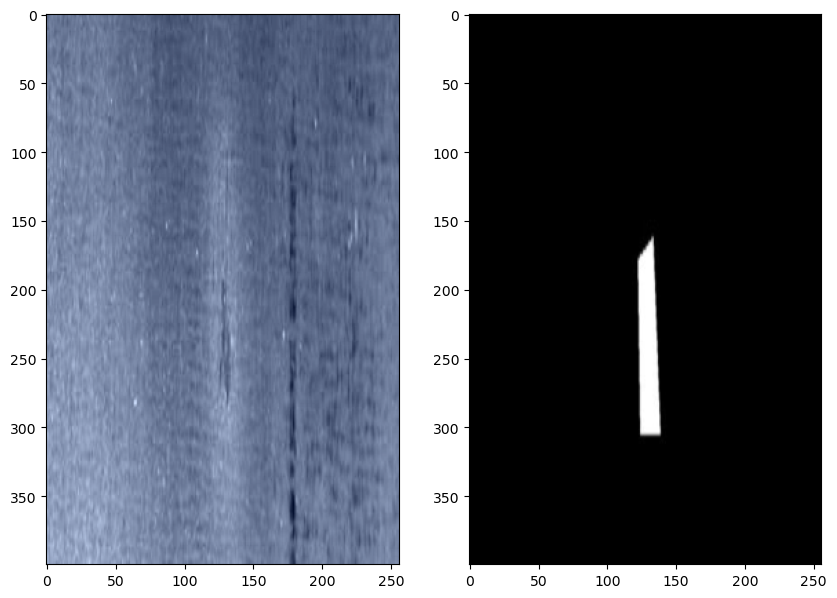

In [164]:
img_idx = 12

img = images[img_idx].permute(1, 2, 0)
img = (img - img.min()) / (img.max() - img.min())
img = img.cpu().numpy()  # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
mask = np.array(masks_gt)[img_idx].squeeze()  # 불필요한 차원 제거

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')  # 이제 mask는 (400, 256) 형태가 되어야 합니다.

In [165]:
aggregator = {"scores": [], "segmentations": []}

## 1. Extract Features > Patchfying > Aggregation

In [166]:
features, patch_shapes = patch_core._embed(images, provide_patch_shapes=True)
features = np.asarray(features)

In [167]:
print('features.shape: ',features.shape)

features.shape:  (2080, 1024)


## 2. Search Neighbour

In [168]:
query_features = patch_core.anomaly_scorer.feature_merger.merge(
    [features],
)

# query_distances: query와의 거리
# query_nns: 이웃 index
query_distances, query_nns = patch_core.anomaly_scorer.imagelevel_nn(query_features)

In [169]:
print('query_distances.shape: ',query_distances.shape)
print('query_nns.shape: ',query_nns.shape)

query_distances.shape:  (2080, 1)
query_nns.shape:  (2080, 1)


## 3. Anomaly Score

In [170]:
patch_scores = image_scores = np.mean(query_distances, axis=-1)

In [171]:
print('patch_scores.shape: ',patch_scores.shape)
print('image_scores.shape: ',image_scores.shape)

patch_scores.shape:  (2080,)
image_scores.shape:  (2080,)


### Image Score

In [172]:
batchsize = images.shape[0]

image_scores = patch_core.patch_maker.unpatch_scores(
    image_scores, batchsize = batchsize
)

In [173]:
print("image_scores.shape: ",image_scores.shape)

image_scores.shape:  (20, 104)


In [174]:
image_scores = image_scores.reshape(*image_scores.shape[:2], -1)

# maximum patch score를 image score로 계산
image_scores = patch_core.patch_maker.score(image_scores)

In [175]:
print("image_scores.shape: ",image_scores.shape)

image_scores.shape:  (20,)


In [176]:
image_scores

array([ 37.059113,  79.399994,  70.96542 ,  39.64435 ,  55.181854,
       107.563354, 258.1725  ,  87.89087 ,  53.065887,  98.86005 ,
       113.562195, 189.9696  ,  38.150604,  55.30078 ,  73.05463 ,
        75.568695,  36.478394,  48.878235,  57.19632 ,  96.30554 ],
      dtype=float32)

### Patch Score

In [177]:
patch_scores = patch_core.patch_maker.unpatch_scores(
    patch_scores, batchsize=batchsize
)

scales = patch_shapes[0]
patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

In [178]:
print("patch_scores.shape: ",patch_scores.shape)

patch_scores.shape:  (20, 13, 8)


In [179]:
masks = patch_core.anomaly_segmentor.convert_to_segmentation(patch_scores)

In [180]:
print('len(masks): ',len(masks))
print('masks[0].shape: ',masks[0].shape)

len(masks):  20
masks[0].shape:  (400, 256)


Text(0.5, 1.0, 'predicted mask')

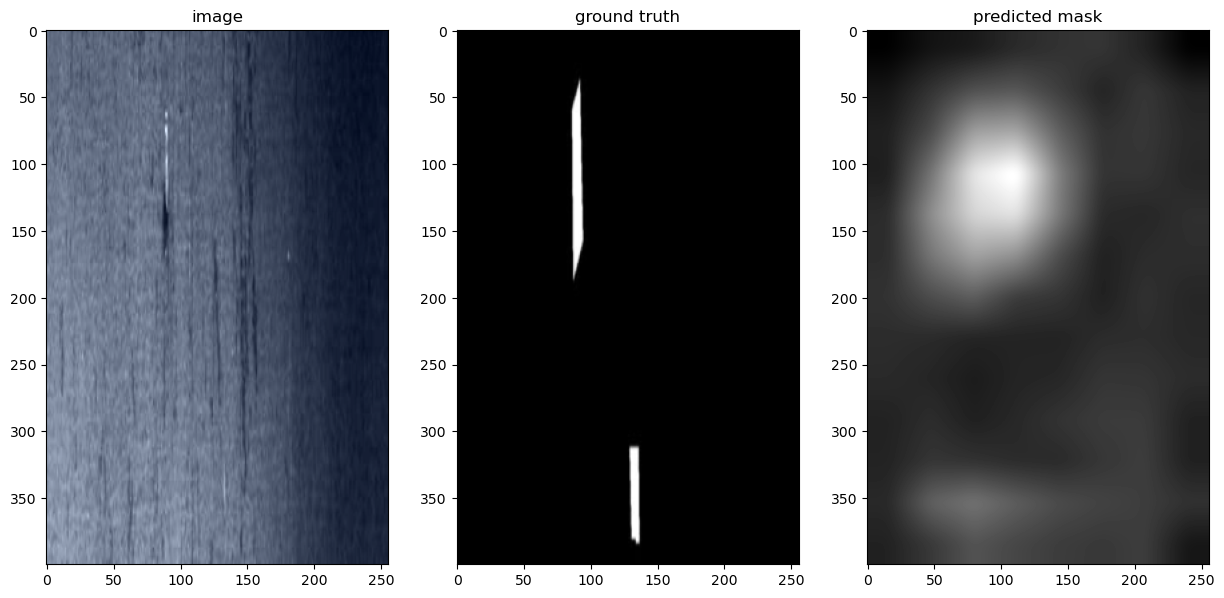

In [185]:
img_idx = 15

img = images[img_idx].permute(1, 2, 0).detach().cpu()
img = (img - img.min()) / (img.max() - img.min())
mask = np.array(masks_gt)[img_idx].squeeze()  # 불필요한 첫 번째 차원을 제거
predicted_mask = masks[img_idx].squeeze()     # 예측 마스크에서도 같은 문제가 발생할 수 있으므로 같은 처리를 적용

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title('image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('ground truth')
ax[2].imshow(predicted_mask, cmap='gray')  # 수정된 예측 마스크
ax[2].set_title('predicted mask')


## 1 ~ 3. prediction

In [156]:
scores, segmentations, labels_gt, masks_gt = patch_core.predict(
    test_dataloader
)

# Evaluation

In [157]:
# score scaling
scores = np.array(scores)
min_scores = scores.min(axis=-1).reshape(-1, 1)
max_scores = scores.max(axis=-1).reshape(-1, 1)
scores = (scores - min_scores) / (max_scores - min_scores)
scores = np.mean(scores, axis=0)

In [158]:
# segmentation scaling
segmentations = np.array(segmentations)
min_scores = (
    segmentations.reshape(len(segmentations), -1)
    .min(axis=-1)
    .reshape(-1, 1, 1, 1)
)
max_scores = (
    segmentations.reshape(len(segmentations), -1)
    .max(axis=-1)
    .reshape(-1, 1, 1, 1)
)
segmentations = (segmentations - min_scores) / (max_scores - min_scores)
segmentations = np.mean(segmentations, axis=0)

In [159]:
anomaly_labels = [
    x[1] != "good" for x in test_dataloader.dataset.data_to_iterate
]

## 1. segmentation images

In [160]:
# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]

# image_paths = [
#     x[2] for x in test_dataloader.dataset.data_to_iterate
# ]
# mask_paths = [
#     x[3] for x in test_dataloader.dataset.data_to_iterate
# ]

# def image_transform(image):
#     in_std = np.array(
#         IMAGENET_STD
#     ).reshape(-1, 1, 1)
#     in_mean = np.array(
#         IMAGENET_MEAN
#     ).reshape(-1, 1, 1)
#     image = test_dataloader.dataset.transform_img(image)
#     return np.clip(
#         (image.numpy() * in_std + in_mean) * 255, 0, 255
#     ).astype(np.uint8)

# def mask_transform(mask):
#     return test_dataloader.dataset.transform_mask(mask).numpy()

# image_save_path = os.path.join(
#     './figures', "segmentation_images", "bottle"
# )
# os.makedirs(image_save_path, exist_ok=True)

# utils.plot_segmentation_images(
#     image_save_path,
#     image_paths,
#     segmentations,
#     scores,
#     mask_paths,
#     image_transform=image_transform,
#     mask_transform=mask_transform,
# )

In [161]:
auroc = metrics.compute_imagewise_retrieval_metrics(
    scores, anomaly_labels
)["auroc"]

# Compute PRO score & PW Auroc for all images
pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
    segmentations, masks_gt
)
full_pixel_auroc = pixel_scores["auroc"]

# Compute PRO score & PW Auroc only images with anomalies
sel_idxs = []
for i in range(len(masks_gt)):
    if np.sum(masks_gt[i]) > 0:
        sel_idxs.append(i)
        
pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
    [segmentations[i] for i in sel_idxs],
    [masks_gt[i] for i in sel_idxs],
)
anomaly_pixel_auroc = pixel_scores["auroc"]

In [186]:
print('Detection AUROC: ',auroc)
print('Segmentation AUROC: ',full_pixel_auroc)
print('Segmentation AUROC of abnormal images: ',anomaly_pixel_auroc)

Detection AUROC:  0.8833333333333333
Segmentation AUROC:  0.8379436870646914
Segmentation AUROC of abnormal images:  0.8030141002067421
